# Implementacja zaawansowanych metod analizy tekstu w Pythonie
### Kod realizuje zadanie na nietypowym zbiorze danych: Sztuczna Inteligencja (AI) vs Ogrodnictwo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec, LdaModel
from gensim.corpora.dictionary import Dictionary
import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize
import random

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/reuters')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('reuters')
    nltk.download('stopwords')

# KROK 1: Ładowanie korpusu Reuters
# Dwie bardzo różne kategorie: 'grain' (zboże) i 'crude' (ropa)
categories = ['grain', 'crude']
documents = []
labels = []

# Identyfikatory dokumentów dla wybranych kategorii
for cat in categories:
    file_ids = reuters.fileids(cat)
    selected_ids = file_ids[:200]
    
    for fid in selected_ids:
        documents.append(reuters.raw(fid))
        labels.append(cat)

print(f"\nZaładowano {len(documents)} dokumentów.")
print(f"Kategorie: {categories}")
print(f"Przykład tekstu ({labels[0]}): {documents[0][:150]}...")

Pobieranie zasobów NLTK (może chwilę potrwać)...

Załadowano 400 dokumentów.
Kategorie: ['grain', 'crude']
Przykład tekstu (grain): CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  showed vermin consume between seven and 12 pct of Chin...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maciek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Maciek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Maciek\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maciek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Komórka 2: Wektoryzacja tekstu (TF-IDF)
### Ten blok zamienia tekst na macierz liczbową.

In [14]:
# KROK 2: Tokenizacja i TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, token_pattern=r'(?u)\b[a-zA-Z]{3,}\b')
tfidf_matrix = vectorizer.fit_transform(documents)

feature_names = vectorizer.get_feature_names_out()

print(f"Wymiary macierzy TF-IDF: {tfidf_matrix.shape}")

# Topowe słowa dla pierwszego dokumentu (zboże)
first_doc_vector = tfidf_matrix[0]
df_tfidf = pd.DataFrame(first_doc_vector.T.todense(), index=feature_names, columns=["waga"])
print("\nNajważniejsze słowa w przykładowym dokumencie (Grain):")
print(df_tfidf.sort_values(by="waga", ascending=False).head(5))

Wymiary macierzy TF-IDF: (400, 1000)

Najważniejsze słowa w przykładowym dokumencie (Grain):
             waga
china    0.517860
pct      0.312019
storage  0.310642
daily    0.282029
seven    0.255770


# Komórka 3: Word Embeddings (Word2Vec)
### Ten blok uczy się znaczenia słów i sprawdza ich podobieństwo.

In [15]:
# KROK 3: Word2Vec
print("Przygotowanie modelu Word2Vec...")
sentences = [word_tokenize(text.lower()) for text in documents]

# Trenowanie
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=50)

# Test podobieństwa: czy 'wheat' (pszenica) jest bliżej 'corn' (kukurydza) czy 'oil' (ropa)?
try:
    word_main = 'wheat'
    word_same = 'corn'
    word_diff = 'oil'
    
    if all(w in model_w2v.wv for w in [word_main, word_same, word_diff]):
        sim_same = model_w2v.wv.similarity(word_main, word_same)
        sim_diff = model_w2v.wv.similarity(word_main, word_diff)
        
        print(f"\nPodobieństwo '{word_main}' - '{word_same}': {sim_same:.3f}")
        print(f"Podobieństwo '{word_main}' - '{word_diff}': {sim_diff:.3f}")
    else:
        print("Wybrane słowa nie występują w słowniku (zbyt mały zbiór).")
        print("Podobne do 'tonnes':", model_w2v.wv.most_similar('tonnes', topn=3))

except KeyError as e:
    print(f"Błąd słownika: {e}")

Przygotowanie modelu Word2Vec...

Podobieństwo 'wheat' - 'corn': 0.544
Podobieństwo 'wheat' - 'oil': -0.219


# Komórka 4: Analiza Tematyczna (LDA)
### Ten blok automatycznie wykrywa 2 tematy w tekstach.

In [11]:
# KROK 4: LDA

# Filtrowanie słów
stop_words = set(nltk.corpus.stopwords.words('english'))
# dodanie specyficznych słów, które nic nie wnoszą
stop_words.update(['said', 'would', 'mln', 'pct', 'year', 'last']) 

processed_docs = [[w.lower() for w in doc if w.lower() not in stop_words and w.isalpha() and len(w)>3] for doc in sentences]

dictionary = Dictionary(processed_docs)
# Usunięcie słów, które występują w mniej niż 5 dokumentach lub w więcej niż 50% dokumentów
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Szukanie 2 tematów (Zboże vs Ropa)
lda = LdaModel(corpus, num_topics=2, id2word=dictionary, passes=20, random_state=42)

print("Wykryte tematy:")
for idx, topic in lda.print_topics(num_words=6):
    print(f"Temat {idx}: {topic}")

Wykryte tematy:
Temat 0: 0.015*"wheat" + 0.013*"gulf" + 0.011*"iran" + 0.010*"trade" + 0.009*"iranian" + 0.007*"attack"
Temat 1: 0.032*"tonnes" + 0.022*"dlrs" + 0.016*"prices" + 0.014*"crude" + 0.014*"price" + 0.012*"production"


# Komórka 5: Redukcja wymiarowości i Wizualizacja (SVD)
### Ten blok rysuje wykres, na którym widać, czy grupy tekstów się rozdzieliły.

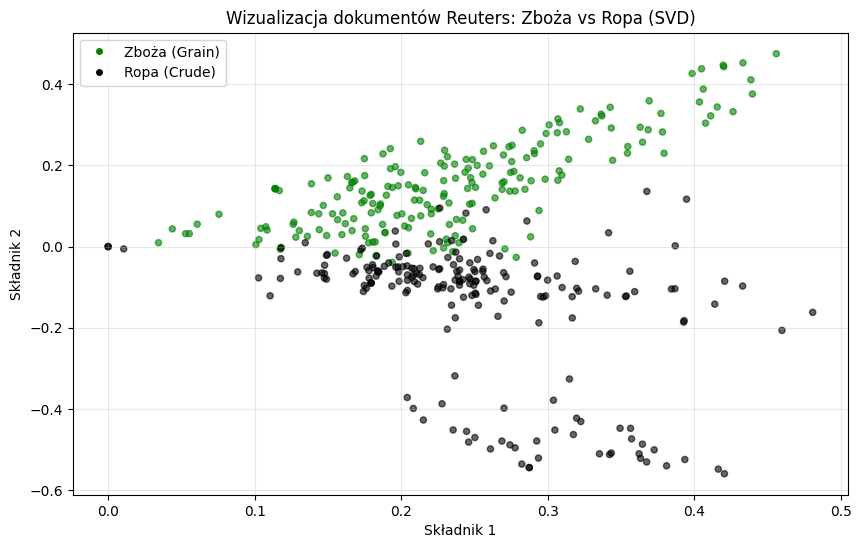

In [12]:
# KROK 5: Wizualizacja SVD (2D)
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(tfidf_matrix)

# Mapowanie etykiet tekstowych na kolory
# grain -> green, crude -> black (ropa)
color_map = {'grain': 'green', 'crude': 'black'}
colors = [color_map[label] for label in labels]

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=colors, alpha=0.6, s=20)

# Legenda
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Zboża (Grain)'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='Ropa (Crude)')]
plt.legend(handles=legend_elements)

plt.title("Wizualizacja dokumentów Reuters: Zboża vs Ropa (SVD)")
plt.xlabel("Składnik 1")
plt.ylabel("Składnik 2")
plt.grid(True, alpha=0.3)
plt.show()